In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/data/images_hur.zip -d /content/images_hur

Streaming output truncated to the last 5000 lines.
  inflating: /content/images_hur/train_another/no_damage/-95.627453_29.859303000000004.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62745600000001_29.777524.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627485_29.777865999999996.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627563_29.8628.jpeg  
  infl

In [4]:
img_paths=[]
img_labels=[]
for i in glob('/content/images_hur/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [5]:
len(img_paths),len(img_labels)

(23000, 23000)

In [6]:
print('We got total '+str(len(img_paths))+' images')

We got total 23000 images


In [7]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
16833,/content/images_hur/train_another/no_damage/-95.666415_29.822573.jpeg,no_damage
13493,/content/images_hur/train_another/damage/-96.90476600000001_28.375337.jpeg,damage
3084,/content/images_hur/test_another/damage/-96.925422_28.758102.jpeg,damage
3345,/content/images_hur/test_another/damage/-95.114195_30.001367.jpeg,damage
10411,/content/images_hur/test_another/no_damage/-95.177468_30.033240999999997.jpeg,no_damage


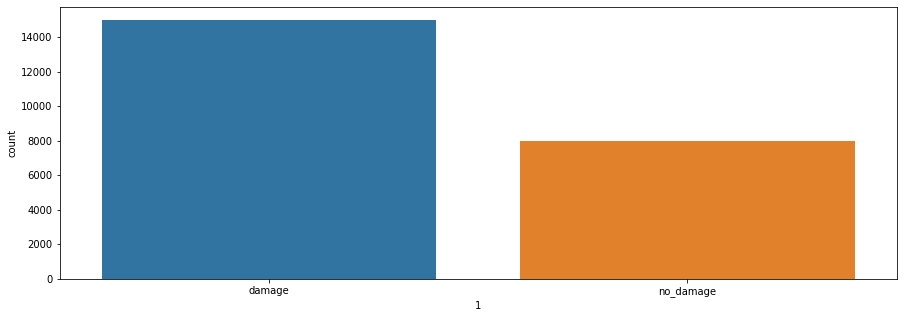

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(x=data[1])

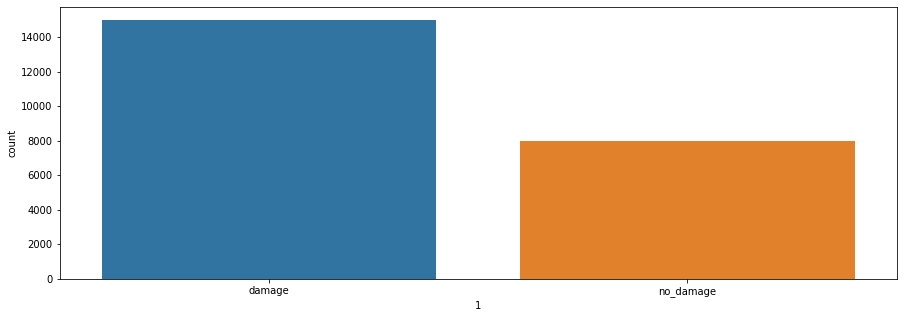

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(x=data[1])

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [11]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [12]:
train_gen = ImageDataGenerator(validation_split=0.1,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)
test_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=100,
    seed=2020
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=100,
    seed=2020
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [15]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
156/156 [==============================] - 261s 2s/step - loss: 1.1098 - accuracy: 0.6099 - recall: 0.5847 - val_loss: 0.6208 - val_accuracy: 0.6661 - val_recall: 0.6412
Epoch 2/15
156/156 [==============================] - 245s 2s/step - loss: 0.9362 - accuracy: 0.6846 - recall: 0.6522 - val_loss: 0.5832 - val_accuracy: 0.6916 - val_recall: 0.6649
Epoch 3/15
156/156 [==============================] - 242s 2s/step - loss: 0.8342 - accuracy: 0.7134 - recall: 0.6849 - val_loss: 0.5278 - val_accuracy: 0.7484 - val_recall: 0.7316
Epoch 4/15
156/156 [==============================] - 244s 2s/step - loss: 0.7457 - accuracy: 0.7460 - recall: 0.7193 - val_loss: 0.4769 - val_accuracy: 0.7814 - val_recall: 0.7484
Epoch 5/15
156/156 [==============================] - 245s 2s/step - loss: 0.6848 - accuracy: 0.7699 - recall: 0.7422 - val_loss: 0.4565 - val_accuracy: 0.8081 - val_recall: 0.7820
Epoch 6/15
156/156 [==============================] - 243s 2s/step - loss: 0.6426 - accuracy: 0

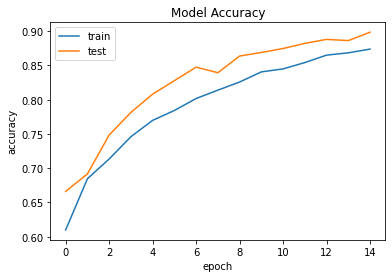

In [16]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

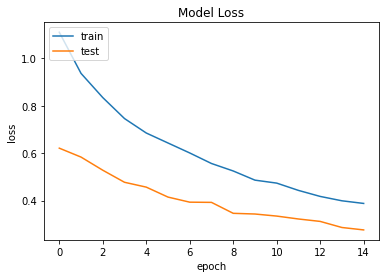

In [17]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3767
           1       0.90      0.81      0.85      1983

    accuracy                           0.90      5750
   macro avg       0.90      0.88      0.89      5750
weighted avg       0.90      0.90      0.90      5750



In [20]:
classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred),
                     index = classes, 
                     columns = classes)


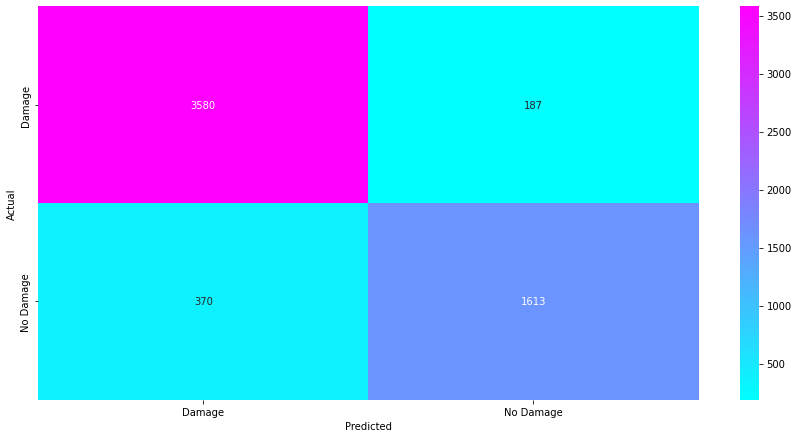

In [21]:
import seaborn as sns
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()